In [149]:
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
from networkx.readwrite import json_graph

In [150]:
import json 
import numpy as np
import re

In [151]:
from scipy import sparse, io
import os
import json
import joblib
import csv

import collections
from collections import Counter
import itertools



In [152]:
user_types = ['ClassDeclaration', 'FormalParameter', 'VariableDeclarator', 'CatchClauseParameter', 'ConstructorDeclaration', 'MethodInvocation', 'MemberReference']

In [153]:
# Build vocab

filename = "data/java/train_java.jsonl"
global_id = 0
n_edges = 0
snippet_count = 0
var_map = {}
name = 'test_js'
max_len = 64
out_path = 'data/java/data'
if not os.path.exists(out_path):
    os.makedirs(out_path)
vocab = Counter()
token_types = Counter()

with open(filename, 'r', encoding="ISO-8859-1") as f:
    for idx, line in enumerate(f):
        data = json.loads(line)
        for r in data:
            #print(r)
            if type(r) == int:
                break
            
            if r['type'] in user_types:
                if r.get('value', None) is not None:
                    #print(r['value'])
                    if len(w.split(' ')) > 1:
                        w = 'Property'
                    else:
                        w = str(r['value'])
                else:
                    w = r['type']
                    #break
            else:
                w = r['type']
                token_types.update([w])

            vocab.update([w])
        #if idx > 10000:
        #    break

KeyboardInterrupt: 

In [ ]:
with open("data/java/test_java.jsonl", 'r', encoding="ISO-8859-1") as f:
    for idx, line in enumerate(f):
        data = json.loads(line)
        for r in data:
            #print(r)
            if type(r) == int:
                break
            
            if r['type'] in ['ClassDeclaration', 'FormalParameter', 'VariableDeclarator', 'CatchClauseParameter', 'ConstructorDeclaration', 'MethodInvocation', 'MemberReference']:
                if r.get('value', None) is not None:
                    #print(r['value'])
                    if len(w.split(' ')) > 1:
                        w = 'Property'
                    else:
                        w = str(r['value'])
                else:
                    w = r['type']
                    #break
            else:
                w = r['type']
                token_types.update([w])

            vocab.update([w])
        #if idx > 10000:
        #    break

In [ ]:
len(vocab)

In [ ]:
vocab_filt = {x : vocab[x] for x in vocab if vocab[x] >= 5}

vocab_low = [v.lower() for v in vocab]


In [ ]:
list(token_types.keys())

In [ ]:
for k in token_types:
    print(k.lower())
    

In [ ]:
with open(os.path.join(out_path, 'java-vocab.txt'), 'a') as f:
    f.write("[PAD]\n")
    f.write("[UNK]\n")
    f.write("[CLS]\n")
    f.write("[SEP]\n")
    f.write("[MASK]\n")
    voc = list(vocab_filt.keys())
    for v in voc:
        f.write(v.lower())
        f.write('\n')
    for k in token_types:
        f.write(k.lower())
        f.write('\n')
    for k in user_types:
        f.write(k.lower())
        f.write('\n')

In [ ]:

voc = list(vocab_filt.keys())
print("Vocabulary length: ", len(voc)+len(user_types)+len(token_types)+5)

In [ ]:
vocab.most_common(100)

In [ ]:
filename = "data/java/train_java.jsonl"
global_id = 0
n_edges = 0
snippet_count = 0
name = 'java'
test_count = 0; train_count = 0
suffix = '_val'
max_len = 128
if not os.path.exists(out_path):
    os.makedirs(out_path)
#vocab = set()

with open(filename, 'r', encoding="ISO-8859-1") as f:
    for idx, line in enumerate(f):
        data = json.loads(line)
        G=nx.Graph()
        row = ["[CLS]"]; row_order = ["[CLS]"]
        for r in data:
            #print(r)
            if type(r) == int:
                break
            from_node = r['uid']
            if r['type'] in ['ClassDeclaration', 'FormalParameter', 'VariableDeclarator', 'CatchClauseParameter', 'ConstructorDeclaration', 'MethodInvocation', 'MemberReference']:
                if r.get('value', None) is not None:
                    if (vocab[r['value']] >= 5):
                        w = str(r['value'])
                    else: 
                        w = r['type']
                    #var_map[str(from_node)] = w
                else:
                    w = r['type']
            else:
                w = r['type']
            
            if w == 'this':
                print(w, r)
                
            row.append(w)

            for to_node in r.get('children', []):
                n_edges += 1
                G.add_edge(from_node, to_node)
            if G.number_of_nodes() > max_len:
                break
                
        if (G.number_of_nodes() < max_len) and (G.number_of_nodes() > 10):
            if np.random.uniform() < 0.2:
                is_train = False
                suffix = '_val'
                prefix = str(test_count)
            else:
                is_train = True
                suffix = ''
                prefix = str(train_count)

            
            # Save tk
            # print(row)
            with open(os.path.join(out_path, prefix+"_"+name+'_tk'+suffix+'.txt'), 'a') as f:
                f.write(' '.join(row))
                sep='\n\n'
                f.write(sep)
                    
            # Save adj
            G_u = G.to_undirected()
            adj = nx.adj_matrix(G_u).todense()
            
            final = np.zeros((max_len,max_len), dtype=int)
            final[1:adj.shape[0]+1, 1:adj.shape[1]+1] = adj
            final += np.eye(max_len, dtype=int)
            final[:,0] = np.ones(max_len)
            final[0,:] = np.ones(max_len)
            
            m = sparse.csr_matrix(final)
            sparsedir = os.path.join(out_path, 'adj')
            if not os.path.exists(sparsedir):
                os.makedirs(sparsedir)
            io.mmwrite(os.path.join(sparsedir, prefix+"_"+name+"_adj"+suffix+".mtx"), m)
            snippet_count += 1
            
            if is_train:
                train_count += 1
            else:
                test_count += 1
        #if idx > 10000:
        #    break

In [ ]:
flatten = lambda x: [item for sublist in x for item in sublist]
cc_split = lambda x: re.sub('(?!^)([A-Z][a-z]+)', r' \1', x).split()

In [ ]:
def full_split(v):
    sp = cc_split(v)
    sp = flatten([ss.split('_') for ss in sp])
    sp = flatten([ss.split('-') for ss in sp])
    sp = flatten([ss.split('/') for ss in sp])
    sp = flatten([ss.split('$') for ss in sp])
    return sp


In [ ]:
sub_vocab = set()
for v in vocab:
    sp = cc_split(v)
    sp = flatten([ss.split('_') for ss in sp])
    sp = flatten([ss.split('-') for ss in sp])
    sp = flatten([ss.split('/') for ss in sp])
    sp = flatten([ss.split('$') for ss in sp])

    for s in sp:
        sub_vocab.add(s)

In [ ]:
len(sub_vocab)

In [ ]:
n_edges

In [ ]:
G.number_of_edges(), G.number_of_nodes()

In [ ]:
line

In [ ]:
import collections
import matplotlib.pyplot as plt
%matplotlib inline 

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items());

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg]);
ax.set_xticklabels(deg);

In [ ]:
degreeCount

In [ ]:
n_edges

In [ ]:
token_types = set()

with open(filename, 'r') as f:
    try:
        for idx, line in enumerate(f):
            data = json.loads(line[:-6]+"]")
            for r in data:
                if type(r) == int:
                    break
                token_types.add(r['type'])
            #break
    except:
        print(idx,line)

In [ ]:
token_types = {'ArrayAccess',
 'ArrayExpression',
 'AssignmentExpression',
 'BinaryExpression',
 'BlockStatement',
 'BreakStatement',
 'CallExpression',
 'CatchClause',
 'ConditionalExpression',
 'ContinueStatement',
 'DoWhileStatement',
 'EmptyStatement',
 'ExpressionStatement',
 'ForInStatement',
 'ForStatement',
 'FunctionDeclaration',
 'FunctionExpression',
 'Identifier',
 'IfStatement',
 'LabeledStatement',
 'LiteralBoolean',
 'LiteralNull',
 'LiteralNumber',
 'LiteralRegExp',
 'LiteralString',
 'LogicalExpression',
 'MemberExpression',
 'NewExpression',
 'ObjectExpression',
 'Program',
 'Property',
 'ReturnStatement',
 'SequenceExpression',
 'SwitchCase',
 'SwitchStatement',
 'ThisExpression',
 'ThrowStatement',
 'TryStatement',
 'UnaryExpression',
 'UpdateExpression',
 'VariableDeclaration',
 'VariableDeclarator',
 'WhileStatement'}

In [ ]:
for k in token_types:
    print(k.lower())
    

In [ ]:
var_map

----

## Method Naming

In [65]:
count_labels = Counter()
with open('../magret/java/methodname/java-train-labels.txt', 'r') as f:
    for l in f:
        count_labels.update([l.strip('\n')])

In [67]:
count_labels.most_common(100)

[('tostring', 316),
 ('main', 118),
 ('writeto', 91),
 ('gethandlerlist', 90),
 ('run', 83),
 ('configure', 80),
 ('get', 77),
 ('create', 64),
 ('hashcode', 61),
 ('parse', 60),
 ('oncreate', 56),
 ('newrequestbuilder', 51),
 ('close', 50),
 ('getcptr', 47),
 ('execute', 37),
 ('initchannel', 36),
 ('call', 35),
 ('status', 35),
 ('handlerequest', 34),
 ('doexecute', 34),
 ('clone', 31),
 ('init', 29),
 ('convert', 28),
 ('equals', 27),
 ('newarray', 27),
 ('dispose', 27),
 ('accept', 26),
 ('exceptioncaught', 26),
 ('build', 25),
 ('oncreateview', 25),
 ('issingleton', 24),
 ('render', 23),
 ('invoke', 22),
 ('encode', 22),
 ('touch', 22),
 ('doxcontent', 22),
 ('buildresponse', 21),
 ('decode', 20),
 ('evaluate', 20),
 ('onclick', 20),
 ('getfunctionparametertypes', 19),
 ('process', 19),
 ('destroy', 19),
 ('getastext', 19),
 ('getmessage', 18),
 ('ondraw', 18),
 ('onnext', 18),
 ('getvalue', 17),
 ('matches', 17),
 ('apply', 17),
 ('deserialize', 16),
 ('reset', 16),
 ('onfailure'

In [155]:
filename = "data/java/train_java.jsonl"
global_id = 0
n_edges = 0
snippet_count = 0
method_labels = []
method_labels_train = [];method_labels_test = []
name = 'java'
suffix = '_val'
test_count = 0; train_count = 0
max_len = 128
if not os.path.exists(out_path):
    os.makedirs(out_path)
#vocab = set()

with open(filename, 'r', encoding="ISO-8859-1") as f:
    for idx, line in enumerate(f):
        is_funcdef = False
        data = json.loads(line)
        G=nx.Graph()
        row = ["[CLS]"]; row_order = ["[CLS]"]
        for r in data:
            #print(r)
            if type(r) == int:
                break
            from_node = r['uid']
            if r['type'] in ['FunctionDeclaration', 'MethodDeclaration']:
                if r.get('value', None) is not None:
                    w = r['type']
                    label = str(r['value'])
                    #print(label)
                    is_funcdef = True
            if r['type'] in ['ClassDeclaration', 'FormalParameter', 'VariableDeclarator', 'SuperMethodInvocation', 'CatchClauseParameter', 'ConstructorDeclaration', 'MethodInvocation', 'MemberReference']:
                if r.get('value', None) is not None:
                    if (vocab[r['value']] >= 5):
                        w = str(r['value'])
                    else: 
                        w = r['type']
            else:
                w = r['type']
            #if is_funcdef:
            row.append(w)

            for to_node in r.get('children', []):
                n_edges += 1
                G.add_edge(from_node, to_node)
            if G.number_of_nodes() > max_len:
                break
                
        if (G.number_of_nodes() < max_len) and (G.number_of_nodes() > 10) and (is_funcdef == True) and (count_method_labels[label] > 1):
            # Save tk
            # print(row)
            if np.random.uniform() < 0.2:
                is_train = False
                suffix = '_val'
                prefix = str(test_count)
                method_labels_test.append(label)

            else:
                is_train = True
                suffix = ''
                prefix = str(train_count)
                method_labels_train.append(label)
            
            with open(os.path.join(out_path, name+'_tk'+suffix+'.txt'), 'a') as f:
                f.write(' '.join(row))
                sep='\n'
                f.write(sep)
                    
            # Save adj
            G_u = G.to_undirected()
            adj = nx.adj_matrix(G_u).todense()
            
            final = np.zeros((max_len,max_len), dtype=int)
            final[1:adj.shape[0]+1, 1:adj.shape[1]+1] = adj
            final += np.eye(max_len, dtype=int)
            final[:,0] = np.ones(max_len)
            final[0,:] = np.ones(max_len)
            
            m = sparse.csr_matrix(final)
            sparsedir = os.path.join(out_path, 'adj')
            if not os.path.exists(sparsedir):
                os.makedirs(sparsedir)
            io.mmwrite(os.path.join(sparsedir, prefix+"_"+name+"_adj"+suffix+".mtx"), m)
            if is_train:
                train_count += 1
            else:
                test_count += 1
            snippet_count += 1
        #if idx > 10000:
        #    break

In [156]:
with open(os.path.join(out_path, 'java-val-labels.txt'), 'a') as f:
    for v in method_labels_test:
        f.write(v.lower()+'\n')

In [157]:
with open(os.path.join(out_path, 'java-train-labels.txt'), 'a') as f:
    for v in method_labels_train:
        f.write(v.lower()+'\n')

In [15]:
with open(os.path.join(out_path, 'java-vocab-labels-val.txt'), 'a') as f:
    for v in list(set(method_labels)):
        f.write(v.lower())
        f.write('\n')

In [115]:
count_method_labels = Counter()

In [116]:
with open('../magret/java/methodname/java-train-labels.txt', 'r') as f:
    for l in f:
        method_labels_all.update([l.strip('\n')])
        count_method_labels.update([l.strip('\n')])

In [117]:
with open('../magret/java/methodname/data-val/java-vocab-labels-val.txt', 'r') as f:
    for l in f:
        method_labels_all.update([l.strip('\n')])
        count_method_labels.update([l.strip('\n')])

In [53]:
with open(os.path.join(out_path, 'java-vocab-labels-all.txt'), 'a') as f:
    for v in list(method_labels_all.keys()):
        f.write(v.lower())
        f.write('\n')


In [113]:
len(Counter(method_labels_all).keys())

5017

In [118]:
count_labels

Counter({'connectionclosed': 5,
         'exceptionmetered': 1,
         'returnsnanwhentheinformationisunavailable': 1,
         'unloadedgauge': 1,
         'measuresgetsandputs': 1,
         'instrumentsconnectiontimes': 1,
         'reloadsthecachedvalueafterthegivenperiod': 1,
         'boundsmeasurementstoatimewindow': 1,
         'autodiscoversthethreadmxbean': 1,
         'getvalue': 17,
         'onlykeepsthemostrecentfrombigdatastreams': 1,
         'onclosed': 1,
         'defaultstousertime': 1,
         'createdefaultdecoratedehcache': 1,
         'getfailures': 1,
         'main': 118,
         'autodiscoverstheruntimebean': 1,
         'returnsatransformedvalue': 1,
         'autodiscoversgcs': 1,
         'querylessurlandmethodwithname': 1,
         'registersexpectedmetricsgivennamestrategy': 1,
         'dumpsallthreads': 1,
         'requireslayout': 2,
         'injectsthemetricregistryintotheservletcontext': 1,
         'updatesthereservoir': 1,
         'getthread

In [127]:
count_method_labels = Counter()
with open('../magret/java-subset/methodname/java-train-labels.txt', 'r') as f:
    for l in f:
        count_method_labels.update([l.strip('\n')])
with open('../magret/java-subset/methodname/java-val-labels.txt', 'r') as f:
    for l in f:
        print(l)
        count_method_labels.update([l.strip('\n')])

main

main

main

equals

equals

setup

process

close

close

equals

close

main

decode

finished

create

accept

deserialize

main

input

configure

cursor

accept

equals

poll

deserialize

equals

accept

main

skip

accept

execute

process

hash

map

cursor

deserialize

deserialize

deserialize

sleep

cast

close

main

list

compare

count

run

cast

failure

remove

compare

main

init

transfer

clone

init

main

read

process

get3

clone

clone

finished

apply

init

create

obtain

run

init

dismiss

println

process

apply

evaluate

size

run

dump

build

finalize

finalizer

dispatch

clone

process

dispose

delete

sleep

delete

read

dispose

dispose

write

resize

dispose

reset

initialize

close

file

delete

delete

resize

load

create

evaluate

set

run

dispose

render

dispose

read

load

push

remove

encode

main

message

touch

encode

touch

configure

remove

touch

configure

register

duplicate

configure

configure

name

configurat

In [128]:
count_method_labels.keys()

dict_keys(['run', 'matches', 'main', 'transform', '_deserialize', 'accept', 'bootstrap', 'load', 'compare', 'test', 'equals', 'deserialize', 'build', 'close', 'configure', 'specialize', 'train', 'combine', 'destroy', 'serialize', 'delete', 'finish', 'setup', 'output', 'map', 'execute', 'cursor', 'hello', 'filter', 'finished', 'commit', 'get', 'input', 'apply', 'hash', 'code', 'skip', 'create', 'call', 'reset', 'count', 'invoke', 'reduce', 'read', 'evaluate', 'describe', 'convert', 'log', 'process', 'set', 'init', 'suite', 'remove', 'native_instance', 'stop', 'finalizer', 'dump', 'transfer', 'cancel', 'clone', 'lookup', 'println', 'get3', 'connect', 'dismiss', 'instantiate', 'draw', 'release', 'from', 'block', 'obtain', 'flush', 'finalize', 'dispatch', 'put', 'show', 'peek', 'dispose', 'render', 'copy', 'prepare', 'size', 'resize', 'initialize', 'slice', 'push', 'file', 'poll', 'iterator', 'write', 'tint', 'handle', 'resume', 'generate', 'encode', 'keys', 'clear', 'touch', 'duplicate', 

In [129]:
len({x : count_method_labels[x] for x in count_method_labels if count_method_labels[x] > 1}.keys())

184

In [130]:
thresh_labels = {x : count_method_labels[x] for x in count_method_labels if count_method_labels[x] > 1}

In [131]:
with open(os.path.join(out_path, 'java-vocab-labels-thresh.txt'), 'a') as f:
    for v in list(thresh_labels.keys()):
        f.write(v.lower())
        f.write('\n')

In [160]:
filename = "data/java/train_java.jsonl"
global_id = 0
n_edges = 0
snippet_count = 0
method_labels = []
method_labels_train = [];method_labels_test = []
name = 'java'
suffix = '_val'
test_count = 0; train_count = 0
max_len = 128
if not os.path.exists(out_path):
    os.makedirs(out_path)
#vocab = set()
funcdef_counts = []

with open(filename, 'r', encoding="ISO-8859-1") as f:
    for idx, line in enumerate(f):
        nb_funcdef = 0
        is_funcdef = False
        data = json.loads(line)
        G=nx.Graph()
        row = ["[CLS]"]; row_order = ["[CLS]"]
        funcdef_ids = []
        row_dict = {}
        for r in data:
            #print(r)
            if type(r) == int:
                break
            from_node = r['uid']
            if r['type'] in ['FunctionDeclaration', 'MethodDeclaration']:
                if r.get('value', None) is not None:
                    w = r['type']
                    label = str(r['value'])
                    #print(label)
                    is_funcdef = True
            if r['type'] in ['ClassDeclaration', 'FormalParameter', 'VariableDeclarator', 'SuperMethodInvocation', 'CatchClauseParameter', 'ConstructorDeclaration', 'MethodInvocation', 'MemberReference']:
                if r.get('value', None) is not None:
                    if (vocab[r['value']] >= 5):
                        w = str(r['value'])
                    else: 
                        w = r['type']
            else:
                w = r['type']
            if is_funcdef:
                nb_funcdef += 1
            row.append(w)

            for to_node in r.get('children', []):
                n_edges += 1
                G.add_edge(from_node, to_node)
            if G.number_of_nodes() > max_len:
                break
                
        if (G.number_of_nodes() < max_len) and (G.number_of_nodes() > 10) and (is_funcdef == True) and (count_method_labels[label] > 1):
            # Save tk
            # print(row)
            if np.random.uniform() < 0.2:
                is_train = False
                suffix = '_val'
                prefix = str(test_count)
                method_labels_test.append(label)

            else:
                is_train = True
                suffix = ''
                prefix = str(train_count)
                method_labels_train.append(label)
                    
            # Save adj
            G_u = G.to_undirected()
            adj = nx.adj_matrix(G_u).todense()
            
            final = np.zeros((max_len,max_len), dtype=int)
            final[1:adj.shape[0]+1, 1:adj.shape[1]+1] = adj
            final += np.eye(max_len, dtype=int)
            final[:,0] = np.ones(max_len)
            final[0,:] = np.ones(max_len)
            

            if is_train:
                train_count += 1
            else:
                test_count += 1
            snippet_count += 1
        funcdef_counts.append(nb_funcdef)
        #if idx > 10000:
        #    break

In [161]:
funcdef_counts

[34,
 2,
 34,
 77,
 101,
 68,
 29,
 34,
 41,
 56,
 23,
 42,
 0,
 92,
 64,
 7,
 22,
 112,
 36,
 51,
 32,
 51,
 70,
 120,
 11,
 69,
 0,
 0,
 108,
 71,
 25,
 42,
 4,
 99,
 41,
 87,
 104,
 0,
 35,
 29,
 110,
 99,
 6,
 59,
 74,
 43,
 67,
 25,
 106,
 30,
 54,
 0,
 27,
 86,
 17,
 80,
 14,
 8,
 94,
 96,
 55,
 34,
 37,
 98,
 110,
 84,
 114,
 34,
 20,
 16,
 111,
 63,
 4,
 103,
 17,
 28,
 7,
 94,
 11,
 39,
 51,
 74,
 112,
 60,
 89,
 40,
 108,
 6,
 37,
 17,
 80,
 105,
 0,
 85,
 71,
 34,
 34,
 95,
 118,
 55,
 45,
 0,
 0,
 88,
 98,
 11,
 108,
 18,
 40,
 11,
 32,
 46,
 34,
 75,
 41,
 23,
 68,
 0,
 115,
 0,
 50,
 27,
 47,
 31,
 21,
 112,
 49,
 69,
 105,
 46,
 0,
 115,
 64,
 29,
 4,
 67,
 38,
 0,
 73,
 17,
 115,
 21,
 67,
 45,
 55,
 35,
 22,
 4,
 61,
 0,
 54,
 35,
 98,
 44,
 98,
 103,
 10,
 83,
 61,
 118,
 31,
 0,
 42,
 8,
 99,
 49,
 20,
 0,
 96,
 0,
 56,
 34,
 62,
 54,
 9,
 53,
 55,
 32,
 46,
 35,
 111,
 111,
 113,
 102,
 115,
 65,
 111,
 99,
 6,
 85,
 68,
 0,
 87,
 84,
 55,
 100,
 0,
 82,
 16,
 0,
 5

In [162]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of FuncDef per file')

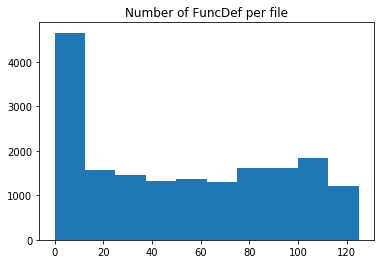

In [164]:
plt.hist(funcdef_counts)
plt.title("Number of FuncDef per file")

In [165]:
np.sum(funcdef_counts)

932381